# PHASE_5_CAPSTONE_PROJECT

## TRANSFER LEARNING-MOBILENETV2

### Data source:

The data source consists of over 44 thousand fashion images from Kaggle.

Source link: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

### Target:

NITA, the multi-brand fashion company, is excited to introduce a cutting-edge feature that allows customers to perform image-based searches. With this new capability, the website can identify product types, empowering users to explore the top 5 closely matched products, resulting in a captivating and personalized shopping experience.

### Transfer learning


Transfer learning is a machine learning technique where a model trained on one task is used as a starting point to solve a different but related task. Instead of training a model from scratch on the new task, transfer learning leverages the knowledge gained during the training of the source task to achieve better performance and efficiency on the target task.

The process of transfer learning involves taking a pre-trained model (often trained on a large dataset, like ImageNet for image-related tasks) and adapting it to the new task by fine-tuning or retraining some of its layers using the target dataset. The intuition behind transfer learning is that the features learned by the model during the source task are general and can be helpful for related tasks.

The benefit of transfer learning: 
- Reduced training time: Since the model is initialized with pre-trained weights, it converges faster during training, saving time and computational resources.

- Better generalization: Transfer learning allows the model to learn relevant features from the source task that can generalize well to the target task, even when the target task has limited data.

- Overcoming data scarcity: In scenarios where the target task has a small dataset, transfer learning can prevent overfitting and improve performance.

### MobileNetV2 introduction

MobileNetV2 is a pre-trained model developed by Google on the ImageNet dataset, a large dataset consisting of 1.4 millions images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories.

MobileNetV2 is a lightweight and efficient convolutional neural network (CNN) architecture designed for mobile and embedded vision applications. It employs depth-wise separable convolutions and linear bottlenecks to reduce computational complexity while maintaining high accuracy. MobileNetV2 is well-suited for resource-constrained devices due to its small size and faster inference speed compared to traditional CNN models.

MobileNetV2 architecture:

- Input Layer: The model takes an input image of shape (height, width, channels).

- Initial Convolution Layer: The input image passes through an initial convolutional layer with a small kernel size and a stride of 2. This layer helps capture basic features from the input.

- Bottleneck Blocks: MobileNetV2 consists of several bottleneck blocks. Each bottleneck block is composed of three key layers:
    - Point-wise Convolution: This is a 1x1 convolution that applies a linear combination of channels from the depth-wise convolution output. It helps to create cross-channel interactions.
    
    - Depth-wise Convolution: This layer applies separate convolutions to each channel of the input. It uses a small kernel size (e.g., 3x3) and does not perform any cross-channel interactions, making it computationally efficient.
    
    - Linear Bottleneck: This is an important concept in MobileNetV2. It reduces the number of input channels before applying the depth-wise and point-wise convolutions, which reduces computational complexity. The linear bottleneck is characterized by an expansion factor, which controls the number of input and output channels.

- Inverted Residuals: MobileNetV2 utilizes inverted residual blocks, which are extensions of the bottleneck blocks. Inverted residuals help maintain representational capacity while keeping the model compact. They involve a combination of expanding the number of channels and then squeezing them back to the desired number using 1x1 convolutions. Or it can be describe that it skips connections exist between narrow parts of the network.

- Final Layers: The final part of the model typically involves a global average pooling layer, followed by a fully connected layer or convolutional layer with a softmax activation for classification tasks. The exact architecture of this part depends on the specific task the model is trained for.

Comparing with CNN Model:

- The inverted residual block in MobileNetV2 reduces parameters through depth-wise separable convolutions and improves efficiency with skip connections, making it lightweight and fast for mobile and edge devices.

Model input size: 224 x 224.

In [40]:
import pandas as pd
import numpy as np
import csv
import json
import glob
import os
import shutil
import random
import pickle
import h5py
import hdf5storage
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from keras import layers
from keras.models import Sequential
from keras.layers import Reshape
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import Input
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'


# Define the image size and number of classes
image_size_224 = (224, 224)
num_classes = 10 


# specialized mobilenetv2 preprocesser
mobilenetv2_processor = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the train_datagen with vgg_processor
train_datagen_mobilenetv2 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False,
                                   preprocessing_function=mobilenetv2_processor)

# Create the val_datagen with vgg_processor
val_datagen_mobilenetv2 = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=mobilenetv2_processor)

# Create the test_datagen with vgg_processor
test_datagen_mobilenetv2 = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=mobilenetv2_processor)

# ...

# Flow data from the directory using the data generators
train_generator_mobilenetv2 = train_datagen_mobilenetv2.flow_from_directory(directory=train_data_dir,
                                                    target_size=image_size_224,
                                                    class_mode='categorical',
                                                    batch_size=64,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_mobilenetv2 = val_datagen_mobilenetv2.flow_from_directory(directory=val_data_dir,
                                                target_size=image_size_224,
                                                class_mode='categorical',
                                                batch_size=64,
                                                shuffle=True,
                                                classes=[str(i) for i in range(num_classes)])

test_generator_mobilenetv2 = test_datagen_mobilenetv2.flow_from_directory(directory=test_data_dir,
                                                  target_size=image_size_224,
                                                  class_mode='categorical',
                                                  batch_size=64,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])


Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


### MobileNetV2 Model 1

Initialize the model with setting weights='imagenet', which will automatically initialize all the weights learned during its original training on ImangeNet. This allows the model to have some pre-learned knowledge of visual features from a wide variety of objects and scenes.

By setting 'include_top'=False, the fully connect layers (also known as the 'top' layers) of the MobileNetV2 model are excluded. The top layers of the model are responsible for the final classification task that was specific to ImageNet's original classes. By excluding the top layers, we can use the MobileNetV2 model as a feature extractor and later add our own custom layers suitable for our 10 classes classification task.

layer.trainable = False, this step freezes the layers, meaning that the weights of these layers will not be updated during the training. By freezing the layers, we prevent their learned features from being modified, allowing us to use the pre-train knowledge without altering it. Only the additional layers we add on the top will be trainbale and learn from our new data.

In [3]:
base_mobilenetv2_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

for layer in base_mobilenetv2_model.layers:
    layer.trainable = False


MobileNetV2 has 154 layers.

In [4]:
len(base_mobilenetv2_model.layers)

154

In [5]:
base_mobilenetv2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, None, None, 144)      0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, None, None, 144)      0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, None, None, 144)      1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, None, None, 144)      576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, None, None, 192)      768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, None, None, 192)      0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, None, None, 64)       12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, None, None, 64)       256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, None, None, 64)       0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, None, None, 384)      24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, None, None, 384)      1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, None, None, 384)      0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, None, None, 576)      0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, None, None, 576)      0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, None, None, 576)      5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, None, None, 960)      3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, None, None, 960)      0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, None, None, 320)      307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In our initial model, we will use the first MobileNetV2 architecture without unfreezing any layers, followed by GlobalAveragePooling layers and dense layers with 128 neurons.

In [6]:
def custom_classifier(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [7]:
mobilenetv2_model = custom_classifier(base_mobilenetv2_model, num_classes)

In [8]:
mobilenetv2_model.compile(loss='categorical_crossentropy',
                             optimizer='Adam',
                             metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [33]:
history_mobilenetv2_model = mobilenetv2_model.fit(train_generator_mobilenetv2,
                                                  steps_per_epoch=len(train_generator_mobilenetv2),
                                                  epochs=50,
                                                  validation_data=val_generator_mobilenetv2,
                                                  validation_steps=len(val_generator_mobilenetv2))

Epoch 1/50
231/231 [==============================] - 111s 481ms/step - loss: 1.9862 - accuracy: 0.3153 - auc: 0.7379 - precision: 0.5106 - recall: 0.0049 - val_loss: 1.7678 - val_accuracy: 0.4239 - val_auc: 0.8353 - val_precision: 0.3208 - val_recall: 0.0034
Epoch 2/50
231/231 [==============================] - 110s 473ms/step - loss: 1.8599 - accuracy: 0.3437 - auc: 0.7888 - precision: 0.5323 - recall: 0.0251 - val_loss: 1.5701 - val_accuracy: 0.4006 - val_auc: 0.8713 - val_precision: 0.4780 - val_recall: 0.1980
Epoch 3/50
231/231 [==============================] - 110s 476ms/step - loss: 1.7418 - accuracy: 0.3722 - auc: 0.8251 - precision: 0.5511 - recall: 0.0423 - val_loss: 1.4762 - val_accuracy: 0.4328 - val_auc: 0.8844 - val_precision: 0.6811 - val_recall: 0.1117
Epoch 4/50
231/231 [==============================] - 117s 507ms/step - loss: 1.6525 - accuracy: 0.3915 - auc: 0.8459 - precision: 0.5992 - recall: 0.0670 - val_loss: 1.4076 - val_accuracy: 0.4324 - val_auc: 0.8926 - val

#### Save model & history

I have saved the model and commented them out to avoid duplicate saves.

In [92]:
# mobilenetv2_model.save('mobilenetv2_base_model_50epoch.h5')

In [93]:
# hdf5storage.savemat("history_mobilenetv2_base_model_epoch.h5", history_mobilenetv2_model.history)

#### Evaluate the model

Reload the model and history for further analysis.

In [9]:
base_mobilenetv2_model_loaded = load_model('mobilenetv2_base_model_50epoch.h5')

In [53]:
base_mobilenetv2_model_loaded.evaluate(train_generator_mobilenetv2)

231/231 [==============================] - 103s 446ms/step - loss: 1.1694 - accuracy: 0.5510 - auc: 0.9242 - precision: 0.7411 - recall: 0.3267


[1.1693661212921143,
 0.5510079860687256,
 0.9241659641265869,
 0.7411385774612427,
 0.3267487585544586]

In [48]:
base_mobilenetv2_model_loaded.evaluate(val_generator_mobilenetv2)

78/78 [==============================] - 24s 304ms/step - loss: 0.9315 - accuracy: 0.6371 - auc: 0.9518 - precision: 0.7810 - recall: 0.5023


[0.9315226674079895,
 0.637082040309906,
 0.9518070220947266,
 0.7810333967208862,
 0.5023303031921387]

In [52]:
base_mobilenetv2_model_loaded.evaluate(test_generator_mobilenetv2)

77/77 [==============================] - 25s 315ms/step - loss: 0.9373 - accuracy: 0.6320 - auc: 0.9510 - precision: 0.7735 - recall: 0.4978


[0.937319278717041,
 0.6319528818130493,
 0.9509638547897339,
 0.7735015749931335,
 0.4977669417858124]

In [10]:
history_base_mobilenetv2_model_loaded = hdf5storage.loadmat("history_mobilenetv2_base_model_epoch.h5")

In [11]:
print(history_base_mobilenetv2_model_loaded.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


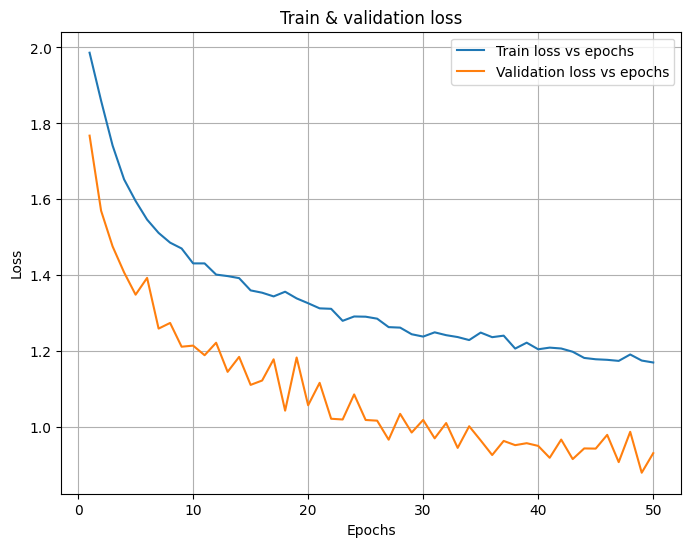

In [12]:
fig,ax=plt.subplots(figsize=(8,6))

base_mobilenev2_loss_values = history_base_mobilenetv2_model_loaded['loss']
base_mobilenev2__val_loss_values = history_base_mobilenetv2_model_loaded['val_loss']


epochs = range(1,len(base_mobilenev2_loss_values)+1)

ax.plot(epochs,base_mobilenev2_loss_values,label='Train loss vs epochs')
ax.plot(epochs,base_mobilenev2__val_loss_values,label='Validation loss vs epochs')

ax.set_title('Train & validation loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Loss');

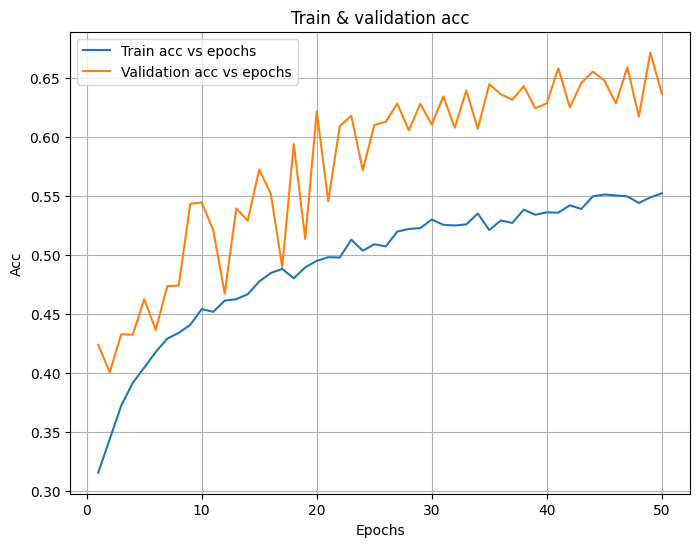

In [13]:
fig,ax=plt.subplots(figsize=(8,6))

base_mobilenev2_acc_values = history_base_mobilenetv2_model_loaded['accuracy']
base_mobilenev2_val_acc_values = history_base_mobilenetv2_model_loaded['val_accuracy']


epochs = range(1,len(base_mobilenev2_acc_values)+1)

ax.plot(epochs,base_mobilenev2_acc_values,label='Train acc vs epochs')
ax.plot(epochs,base_mobilenev2_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

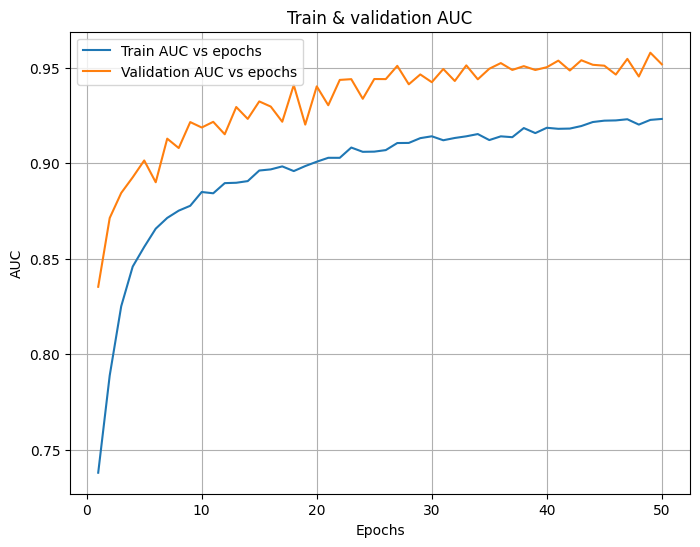

In [14]:
fig,ax=plt.subplots(figsize=(8,6))

base_mobilenev2_AUC_values = history_base_mobilenetv2_model_loaded['auc']
base_mobilenev2_val_AUC_values = history_base_mobilenetv2_model_loaded['val_auc']


epochs = range(1,len(base_mobilenev2_AUC_values)+1)

ax.plot(epochs,base_mobilenev2_AUC_values,label='Train AUC vs epochs')
ax.plot(epochs,base_mobilenev2_val_AUC_values,label='Validation AUC vs epochs')

ax.set_title('Train & validation AUC')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('AUC');

In [15]:
len(mobilenetv2_model.layers)

157

In [16]:
mobilenetv2_test_class_pred = base_mobilenetv2_model_loaded.predict(test_generator_mobilenetv2,steps=len(test_generator_mobilenetv2))

77/77 [==============================] - 23s 300ms/step


In [17]:
mobilenetv2_predicted_classes = np.argmax(mobilenetv2_test_class_pred, axis=-1)
mobilenetv2_predicted_classes

array([0, 0, 0, ..., 9, 4, 6])

In [18]:
mobilenetv2_test_true_classes = test_generator_mobilenetv2.classes
mobilenetv2_test_true_classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [19]:
mobilenetv2_test_class_labels = list(test_generator_mobilenetv2.class_indices.keys()) 
mobilenetv2_test_class_labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [20]:
mobilenetv2_test_class_labels_mapping = {0: 'Tshirts', 1: 'Shirts', 2: 'casual_shoes',3: 'watches' , 4: 'sports_shoes', 5: 'kurtas',6:'handbags',7:'heels',8:'sunglasses',9:'wallets'}
mobilenetv2_test_class_labels_words = list(mobilenetv2_test_class_labels_mapping.values())
mobilenetv2_test_class_labels_words

['Tshirts',
 'Shirts',
 'casual_shoes',
 'watches',
 'sports_shoes',
 'kurtas',
 'handbags',
 'heels',
 'sunglasses',
 'wallets']

In [21]:
mobilenetv2_cm_digits = confusion_matrix(mobilenetv2_test_true_classes, mobilenetv2_predicted_classes)
mobilenetv2_cm_digits

array([[1044,   12,   37,   83,   14,  145,   48,    4,    5,   22],
       [ 223,  194,    1,    9,    0,  206,    1,    0,    1,    8],
       [   1,    0,  360,    0,  191,    0,    1,    0,    3,   13],
       [  90,    0,   13,  365,   10,    2,   20,    3,    1,    4],
       [   0,    0,  111,    0,  287,    0,    2,    0,    1,    6],
       [  26,    4,    0,    2,    0,  337,    0,    0,    0,    0],
       [   5,    2,   80,    8,   33,    0,  193,    0,    2,   29],
       [   3,    0,  160,    0,   81,    0,    0,    9,    7,    4],
       [   0,    0,   18,    0,    0,    0,    0,    1,  185,    9],
       [   0,    0,   38,    2,    3,    0,    5,    0,    0,  139]])

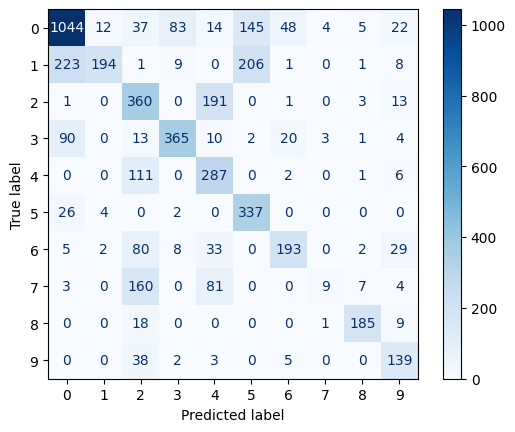

In [22]:
mobilenetv2_disp = ConfusionMatrixDisplay(
    confusion_matrix=mobilenetv2_cm_digits)

mobilenetv2_disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
mobilenetv2_report = classification_report(mobilenetv2_test_true_classes, mobilenetv2_predicted_classes, target_names=mobilenetv2_test_class_labels_words,)
print(mobilenetv2_report)

              precision    recall  f1-score   support

     Tshirts       0.75      0.74      0.74      1414
      Shirts       0.92      0.30      0.45       643
casual_shoes       0.44      0.63      0.52       569
     watches       0.78      0.72      0.75       508
sports_shoes       0.46      0.71      0.56       407
      kurtas       0.49      0.91      0.64       369
    handbags       0.71      0.55      0.62       352
       heels       0.53      0.03      0.06       264
  sunglasses       0.90      0.87      0.89       213
     wallets       0.59      0.74      0.66       187

    accuracy                           0.63      4926
   macro avg       0.66      0.62      0.59      4926
weighted avg       0.68      0.63      0.61      4926



In [26]:
mobilenetv2_report_output = classification_report(mobilenetv2_test_true_classes, mobilenetv2_predicted_classes, target_names=mobilenetv2_test_class_labels_words,output_dict=True)
print(mobilenetv2_report_output)

{'Tshirts': {'precision': 0.75, 'recall': 0.7383309759547383, 'f1-score': 0.7441197434069851, 'support': 1414}, 'Shirts': {'precision': 0.9150943396226415, 'recall': 0.30171073094867806, 'f1-score': 0.4538011695906433, 'support': 643}, 'casual_shoes': {'precision': 0.4400977995110024, 'recall': 0.632688927943761, 'f1-score': 0.5191059841384282, 'support': 569}, 'watches': {'precision': 0.7782515991471215, 'recall': 0.718503937007874, 'f1-score': 0.7471852610030707, 'support': 508}, 'sports_shoes': {'precision': 0.46365105008077545, 'recall': 0.7051597051597052, 'f1-score': 0.5594541910331384, 'support': 407}, 'kurtas': {'precision': 0.48840579710144927, 'recall': 0.9132791327913279, 'f1-score': 0.6364494806421152, 'support': 369}, 'handbags': {'precision': 0.7148148148148148, 'recall': 0.5482954545454546, 'f1-score': 0.6205787781350482, 'support': 352}, 'heels': {'precision': 0.5294117647058824, 'recall': 0.03409090909090909, 'f1-score': 0.06405693950177936, 'support': 264}, 'sunglasse

In [28]:
mobilenetv2_f1_scores = {class_name: mobilenetv2_report_output[class_name]['f1-score'] for class_name in mobilenetv2_test_class_labels_words}
mobilenetv2_f1_scores_rounded = {class_name: round(score, 2) for class_name, score in mobilenetv2_f1_scores.items()}
mobilenetv2_f1_scores_rounded

{'Tshirts': 0.74,
 'Shirts': 0.45,
 'casual_shoes': 0.52,
 'watches': 0.75,
 'sports_shoes': 0.56,
 'kurtas': 0.64,
 'handbags': 0.62,
 'heels': 0.06,
 'sunglasses': 0.89,
 'wallets': 0.66}

In [29]:
mobilenetv2_model_precision = mobilenetv2_report_output['weighted avg']['precision']
mobilenetv2_model_precision

0.6817460549436974

In [30]:
mobilenetv2_model_recall = mobilenetv2_report_output['weighted avg']['recall']
mobilenetv2_model_recall

0.6319529029638652

In [31]:
mobilenetv2_model_f1score = mobilenetv2_report_output['weighted avg']['f1-score']
mobilenetv2_model_f1score

0.6148693093702069

In [32]:
mobilenetv2_model_accuracy = accuracy_score(mobilenetv2_test_true_classes, mobilenetv2_predicted_classes)
mobilenetv2_model_accuracy

0.6319529029638652

In [41]:
test_true_classes_onehot = tf.keras.utils.to_categorical(mobilenetv2_test_true_classes, num_classes=num_classes)

mobilenetv2_model_mean_auc = roc_auc_score(test_true_classes_onehot, mobilenetv2_test_class_pred, multi_class='ovr', average='macro')
mobilenetv2_model_mean_auc

0.9538285955253925

In [43]:
table_columns = ['Model Name','Accuracy_All','AUC_All','Precision_All','Recall_All','F1_score_All'] + list(mobilenetv2_f1_scores_rounded.keys())
sumary_table = pd.DataFrame(columns=table_columns)
sumary_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets


In [44]:
sumary_table.loc[0] = ['mobilenetvs2_baseline_model',round(mobilenetv2_model_accuracy,3),round(mobilenetv2_model_mean_auc,3),round(mobilenetv2_model_precision,3),round(mobilenetv2_model_recall,2) ,round(mobilenetv2_model_f1score,2)] + list(mobilenetv2_f1_scores_rounded.values())
sumary_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets
0,mobilenetvs2_baseline_model,0.632,0.954,0.682,0.63,0.61,0.74,0.45,0.52,0.75,0.56,0.64,0.62,0.06,0.89,0.66


The initial MobileNetV2 model achieved a test accuracy of 63%, surpassing its train accuracy of 55%, which indicates that this model might be generalizing well on the unseen data, even better than the data it was specially trained on. This is such as phenomenon, where test accuracy exceeds train accuracy, which can be attributed to several factors:
- One factor can be the presence of data augmentation during the training process, which increases the diversity of training data by applying various transformations like rotations, shifts, and more. It aids in exposing the model to a broader range of examples, leading to improved generalization.
- Another factor might contribute to the higher test accuracy could be the specific distribution of data in the training and test sets. The test set might inadvertently contain examples that are easier for the model to classify correctly due to certain patterns or characteristics that are not as prevalent in the training set. This imbalance in the data distributions could lead to a better performance on the test set.

Besides, within the test set, suprisingly, f1-scores of the shirts product type exhibited the weakest performance, with  only 45%, while casual shoes and sports shoes followed with F1-scores of 52% and 56%, respectively.

Overall, this result is not as high as expected comparing with our baseline's accuracy with 93%.

### Model tuning 1

In [114]:
mobilenetv2_tune4 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

for layer in mobilenetv2_tune4.layers:
    layer.trainable = False

In [115]:
def custom_classifier(base_model, num_classes):
    x = base_model.output
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [116]:
mobilenetv2_model_tune4 = custom_classifier(mobilenetv2_tune4, num_classes)

In [117]:
mobilenetv2_model_tune4.compile(loss='categorical_crossentropy',
                             optimizer='Adam',
                             metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [118]:
history_mobilenetv2_model_tune4 = mobilenetv2_model_tune4.fit(train_generator_mobilenetv2,
                                                  steps_per_epoch=len(train_generator_mobilenetv2),
                                                  epochs=50,
                                                  validation_data=val_generator_mobilenetv2,
                                                  validation_steps=len(val_generator_mobilenetv2))

Epoch 1/50
231/231 [==============================] - 151s 646ms/step - loss: 2.0704 - accuracy: 0.2990 - auc: 0.7231 - precision: 0.2802 - recall: 0.0147 - val_loss: 1.5046 - val_accuracy: 0.3510 - val_auc: 0.8772 - val_precision: 0.5390 - val_recall: 0.0308
Epoch 2/50
231/231 [==============================] - 118s 508ms/step - loss: 1.6332 - accuracy: 0.3803 - auc: 0.8433 - precision: 0.5117 - recall: 0.0886 - val_loss: 1.3869 - val_accuracy: 0.4261 - val_auc: 0.8892 - val_precision: 0.6284 - val_recall: 0.1433
Epoch 3/50
231/231 [==============================] - 112s 485ms/step - loss: 1.5179 - accuracy: 0.4037 - auc: 0.8658 - precision: 0.5895 - recall: 0.1350 - val_loss: 1.2728 - val_accuracy: 0.4630 - val_auc: 0.9064 - val_precision: 0.6541 - val_recall: 0.2537
Epoch 4/50
231/231 [==============================] - 112s 485ms/step - loss: 1.4291 - accuracy: 0.4476 - auc: 0.8825 - precision: 0.6254 - recall: 0.1984 - val_loss: 1.2495 - val_accuracy: 0.4904 - val_auc: 0.9114 - val

231/231 [==============================] - 116s 501ms/step - loss: 0.8929 - accuracy: 0.6497 - auc: 0.9545 - precision: 0.7350 - recall: 0.5379 - val_loss: 0.7234 - val_accuracy: 0.7206 - val_auc: 0.9697 - val_precision: 0.7782 - val_recall: 0.6618
Epoch 33/50
231/231 [==============================] - 115s 497ms/step - loss: 0.8707 - accuracy: 0.6590 - auc: 0.9567 - precision: 0.7435 - recall: 0.5511 - val_loss: 0.9159 - val_accuracy: 0.6462 - val_auc: 0.9543 - val_precision: 0.6917 - val_recall: 0.5947
Epoch 34/50
231/231 [==============================] - 114s 495ms/step - loss: 0.8836 - accuracy: 0.6507 - auc: 0.9555 - precision: 0.7388 - recall: 0.5435 - val_loss: 0.7090 - val_accuracy: 0.7149 - val_auc: 0.9707 - val_precision: 0.7715 - val_recall: 0.6492
Epoch 35/50
231/231 [==============================] - 115s 498ms/step - loss: 0.8554 - accuracy: 0.6655 - auc: 0.9582 - precision: 0.7486 - recall: 0.5645 - val_loss: 0.6527 - val_accuracy: 0.7374 - val_auc: 0.9746 - val_precisi

In [120]:
mobilenetv2_model_tune4.save('mobilenetv2_model_tune4_5epoch.h5')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [121]:
hdf5storage.savemat("history_mobilenetv2_model_tune4_50epoch.h5", history_mobilenetv2_model_tune4.history)

### Model tuning 2 

In [61]:
mobilenetv2_tune7 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

for layer in mobilenetv2_tune7.layers:
    layer.trainable = False

In [62]:
def custom_classifier(base_model, num_classes):
    x = base_model.output
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [63]:
mobilenetv2_model_tune7 = custom_classifier(mobilenetv2_tune7, num_classes)

In [64]:
mobilenetv2_model_tune7.compile(loss='categorical_crossentropy',
                             optimizer='Adam',
                             metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [65]:
history_mobilenetv2_model_tune7 = mobilenetv2_model_tune7.fit(train_generator_mobilenetv2,
                                                  steps_per_epoch=len(train_generator_mobilenetv2),
                                                  epochs=50,
                                                  validation_data=val_generator_mobilenetv2,
                                                  validation_steps=len(val_generator_mobilenetv2))

Epoch 1/50
231/231 [==============================] - 124s 534ms/step - loss: 2.0512 - accuracy: 0.3080 - auc: 0.7391 - precision: 0.3914 - recall: 0.0266 - val_loss: 1.4995 - val_accuracy: 0.3895 - val_auc: 0.8682 - val_precision: 0.3829 - val_recall: 0.0391
Epoch 2/50
231/231 [==============================] - 123s 531ms/step - loss: 1.5742 - accuracy: 0.3848 - auc: 0.8547 - precision: 0.5127 - recall: 0.1028 - val_loss: 1.3680 - val_accuracy: 0.3728 - val_auc: 0.8900 - val_precision: 0.4177 - val_recall: 0.1117
Epoch 3/50
231/231 [==============================] - 124s 535ms/step - loss: 1.4490 - accuracy: 0.4310 - auc: 0.8788 - precision: 0.5905 - recall: 0.1751 - val_loss: 1.3552 - val_accuracy: 0.4111 - val_auc: 0.8919 - val_precision: 0.6049 - val_recall: 0.1151
Epoch 4/50
231/231 [==============================] - 123s 533ms/step - loss: 1.3716 - accuracy: 0.4575 - auc: 0.8922 - precision: 0.6107 - recall: 0.2305 - val_loss: 1.2247 - val_accuracy: 0.4916 - val_auc: 0.9162 - val

231/231 [==============================] - 121s 524ms/step - loss: 0.8491 - accuracy: 0.6641 - auc: 0.9587 - precision: 0.7423 - recall: 0.5628 - val_loss: 0.6637 - val_accuracy: 0.7339 - val_auc: 0.9737 - val_precision: 0.7729 - val_recall: 0.6833
Epoch 33/50
231/231 [==============================] - 128s 552ms/step - loss: 0.8636 - accuracy: 0.6606 - auc: 0.9576 - precision: 0.7419 - recall: 0.5566 - val_loss: 0.6588 - val_accuracy: 0.7467 - val_auc: 0.9741 - val_precision: 0.8046 - val_recall: 0.6825
Epoch 34/50
231/231 [==============================] - 136s 587ms/step - loss: 0.8479 - accuracy: 0.6592 - auc: 0.9587 - precision: 0.7368 - recall: 0.5625 - val_loss: 0.6312 - val_accuracy: 0.7418 - val_auc: 0.9759 - val_precision: 0.7838 - val_recall: 0.6985
Epoch 35/50
231/231 [==============================] - 130s 561ms/step - loss: 0.8494 - accuracy: 0.6670 - auc: 0.9589 - precision: 0.7484 - recall: 0.5686 - val_loss: 0.6268 - val_accuracy: 0.7512 - val_auc: 0.9762 - val_precisi

#### Save the model

Save and comment out the model and its history to avoid duplicate saves.

In [60]:
# mobilenetv2_model_tune7.save('mobilenetv2_model_tune7_50epoch.h5')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
# hdf5storage.savemat("history_mobilenetv2_model_tune7_50epoch.h5", history_mobilenetv2_model_tune7.history)

#### Evaluate the model

In [67]:
mobilenetv2_tune7_model_loaded = load_model('mobilenetv2_model_tune7_50epoch.h5')

In [70]:
mobilenetv2_tune7_model_loaded.evaluate(train_generator_mobilenetv2)

231/231 [==============================] - 91s 393ms/step - loss: 0.7336 - accuracy: 0.7109 - auc: 0.9687 - precision: 0.7713 - recall: 0.6473


[0.7336345911026001,
 0.7108645439147949,
 0.968717098236084,
 0.7713018655776978,
 0.6472737193107605]

In [71]:
mobilenetv2_tune7_model_loaded.evaluate(test_generator_mobilenetv2)

77/77 [==============================] - 27s 344ms/step - loss: 0.5274 - accuracy: 0.7889 - auc: 0.9824 - precision: 0.8226 - recall: 0.7548


[0.5273593664169312,
 0.7888753414154053,
 0.9824443459510803,
 0.8225663900375366,
 0.7547705769538879]

In [69]:
history_mobilenetv2_tune7_model_loaded = hdf5storage.loadmat("history_mobilenetv2_model_tune7_50epoch.h5")

In [74]:
print(history_mobilenetv2_tune7_model_loaded.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


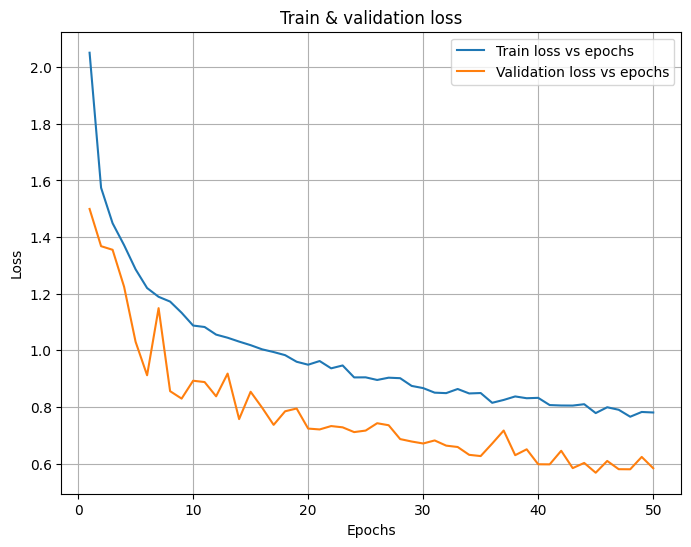

In [75]:
fig,ax=plt.subplots(figsize=(8,6))

mobilenetv2_tune7_loss_values = history_mobilenetv2_tune7_model_loaded['loss']
mobilenetv2_tune7_val_loss_values = history_mobilenetv2_tune7_model_loaded['val_loss']


epochs = range(1,len(mobilenetv2_tune7_loss_values)+1)

ax.plot(epochs,mobilenetv2_tune7_loss_values,label='Train loss vs epochs')
ax.plot(epochs,mobilenetv2_tune7_val_loss_values,label='Validation loss vs epochs')

ax.set_title('Train & validation loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Loss');

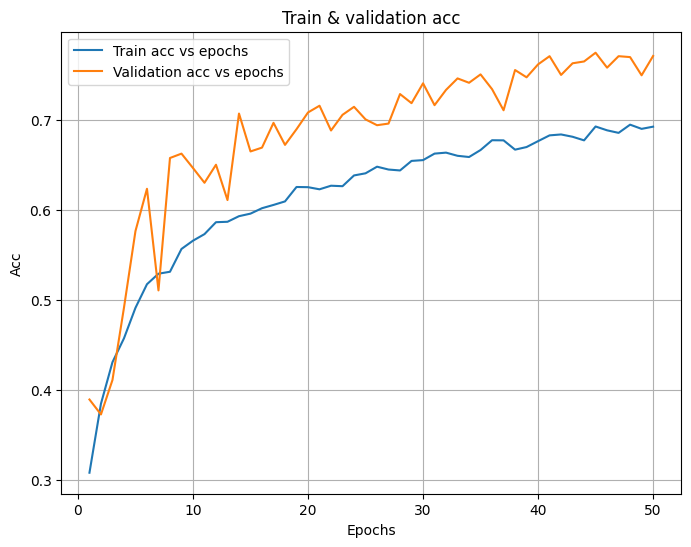

In [76]:
fig,ax=plt.subplots(figsize=(8,6))

mobilenetv2_tune7_acc_values = history_mobilenetv2_tune7_model_loaded['accuracy']
mobilenetv2_tune7_val_acc_values = history_mobilenetv2_tune7_model_loaded['val_accuracy']


epochs = range(1,len(mobilenetv2_tune7_acc_values)+1)

ax.plot(epochs,mobilenetv2_tune7_acc_values,label='Train acc vs epochs')
ax.plot(epochs,mobilenetv2_tune7_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

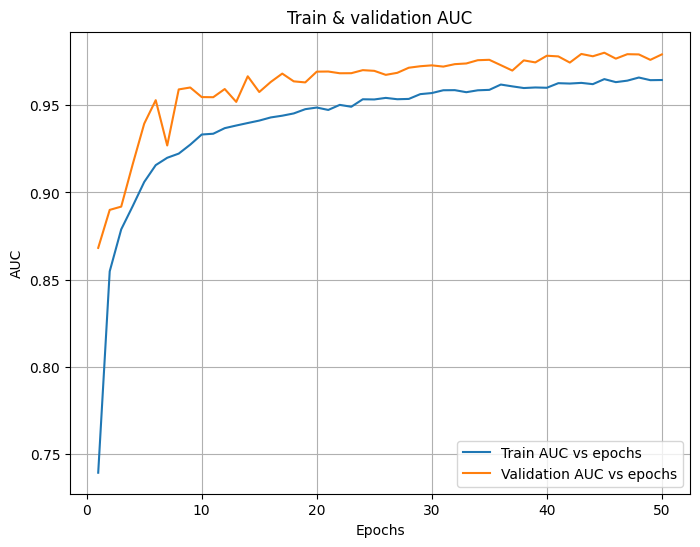

In [77]:
fig,ax=plt.subplots(figsize=(8,6))

mobilenetv2_tune7_AUC_values = history_mobilenetv2_tune7_model_loaded['auc']
mobilenetv2_tune7_val_AUC_values = history_mobilenetv2_tune7_model_loaded['val_auc']


epochs = range(1,len(mobilenetv2_tune7_AUC_values)+1)

ax.plot(epochs,mobilenetv2_tune7_AUC_values,label='Train AUC vs epochs')
ax.plot(epochs,mobilenetv2_tune7_val_AUC_values,label='Validation AUC vs epochs')

ax.set_title('Train & validation AUC')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('AUC');

In [79]:
mobilenetv2_tune7_test_class_pred = mobilenetv2_tune7_model_loaded.predict(test_generator_mobilenetv2,steps=len(test_generator_mobilenetv2))

77/77 [==============================] - 26s 338ms/step


In [81]:
mobilenetv2_tune7_predicted_classes = np.argmax(mobilenetv2_tune7_test_class_pred, axis=-1)
mobilenetv2_tune7_predicted_classes

array([0, 0, 0, ..., 9, 0, 9])

In [84]:
test_true_classes = test_generator_mobilenetv2.classes
test_true_classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [85]:
test_class_labels = list(test_generator_mobilenetv2.class_indices.keys()) 
test_class_labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [86]:
test_class_labels_mapping = {0: 'Tshirts', 1: 'Shirts', 2: 'casual_shoes',3: 'watches' , 4: 'sports_shoes', 5: 'kurtas',6:'handbags',7:'heels',8:'sunglasses',9:'wallets'}
test_class_labels_words = list(test_class_labels_mapping.values())
test_class_labels_words 

['Tshirts',
 'Shirts',
 'casual_shoes',
 'watches',
 'sports_shoes',
 'kurtas',
 'handbags',
 'heels',
 'sunglasses',
 'wallets']

In [88]:
mobilenetv2_tune7_cm_digits = confusion_matrix(test_true_classes, mobilenetv2_tune7_predicted_classes)
mobilenetv2_tune7_cm_digits

array([[1252,   68,    0,   50,    3,   26,    9,    0,    2,    4],
       [ 178,  412,    0,   13,    0,   38,    0,    0,    0,    2],
       [   2,    0,  295,    2,  251,    0,    2,   13,    2,    2],
       [  18,    0,    0,  484,    0,    2,    3,    1,    0,    0],
       [   1,    0,   60,    1,  336,    0,    1,    5,    0,    3],
       [  29,    1,    0,    1,    0,  338,    0,    0,    0,    0],
       [   9,    1,    2,   29,    9,    1,  291,    0,    1,    9],
       [   1,    0,   55,    2,   85,    0,    1,  116,    4,    0],
       [   6,    0,    1,    0,    0,    0,    0,   10,  193,    3],
       [   4,    0,    5,    3,    0,    0,    5,    0,    1,  169]])

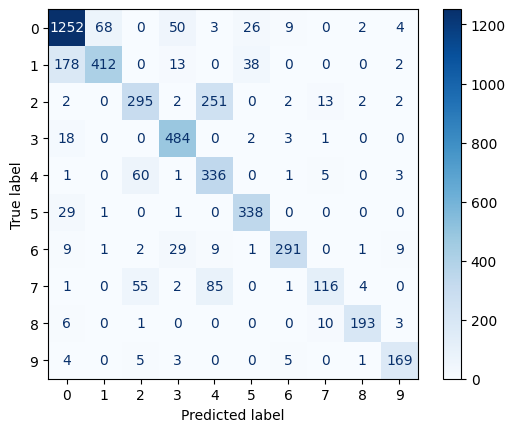

In [89]:
mobilenetv2_tune7_disp = ConfusionMatrixDisplay(
    confusion_matrix=mobilenetv2_tune7_cm_digits)

mobilenetv2_tune7_disp.plot(cmap=plt.cm.Blues)
plt.show()

In [90]:
mobilenetv2_tune7_report = classification_report(test_true_classes, mobilenetv2_tune7_predicted_classes, target_names=test_class_labels_words,)
print(mobilenetv2_tune7_report)

              precision    recall  f1-score   support

     Tshirts       0.83      0.89      0.86      1414
      Shirts       0.85      0.64      0.73       643
casual_shoes       0.71      0.52      0.60       569
     watches       0.83      0.95      0.89       508
sports_shoes       0.49      0.83      0.62       407
      kurtas       0.83      0.92      0.87       369
    handbags       0.93      0.83      0.88       352
       heels       0.80      0.44      0.57       264
  sunglasses       0.95      0.91      0.93       213
     wallets       0.88      0.90      0.89       187

    accuracy                           0.79      4926
   macro avg       0.81      0.78      0.78      4926
weighted avg       0.81      0.79      0.79      4926



In [91]:
mobilenetv2_tune7_report_output = classification_report(test_true_classes, mobilenetv2_tune7_predicted_classes, target_names=test_class_labels_words,output_dict=True)
print(mobilenetv2_tune7_report_output)

{'Tshirts': {'precision': 0.8346666666666667, 'recall': 0.8854314002828855, 'f1-score': 0.8592999313658202, 'support': 1414}, 'Shirts': {'precision': 0.8547717842323651, 'recall': 0.640746500777605, 'f1-score': 0.7324444444444445, 'support': 643}, 'casual_shoes': {'precision': 0.7057416267942583, 'recall': 0.5184534270650264, 'f1-score': 0.5977710233029382, 'support': 569}, 'watches': {'precision': 0.8273504273504273, 'recall': 0.952755905511811, 'f1-score': 0.8856358645928637, 'support': 508}, 'sports_shoes': {'precision': 0.49122807017543857, 'recall': 0.8255528255528255, 'f1-score': 0.6159486709440879, 'support': 407}, 'kurtas': {'precision': 0.8345679012345679, 'recall': 0.9159891598915989, 'f1-score': 0.8733850129198966, 'support': 369}, 'handbags': {'precision': 0.9326923076923077, 'recall': 0.8267045454545454, 'f1-score': 0.8765060240963854, 'support': 352}, 'heels': {'precision': 0.8, 'recall': 0.4393939393939394, 'f1-score': 0.567237163814181, 'support': 264}, 'sunglasses': {'

In [92]:
mobilenetv2_tune7_f1_scores = {class_name: mobilenetv2_tune7_report_output[class_name]['f1-score'] for class_name in test_class_labels_words}
mobilenetv2_tune7_f1_scores_rounded = {class_name: round(score, 2) for class_name, score in mobilenetv2_tune7_f1_scores.items()}
mobilenetv2_tune7_f1_scores_rounded

{'Tshirts': 0.86,
 'Shirts': 0.73,
 'casual_shoes': 0.6,
 'watches': 0.89,
 'sports_shoes': 0.62,
 'kurtas': 0.87,
 'handbags': 0.88,
 'heels': 0.57,
 'sunglasses': 0.93,
 'wallets': 0.89}

In [93]:
mobilenetv2_tune7_model_precision = mobilenetv2_tune7_report_output['weighted avg']['precision']
mobilenetv2_tune7_model_precision

0.8051557747845257

In [94]:
mobilenetv2_tune7_model_recall = mobilenetv2_tune7_report_output['weighted avg']['recall']
mobilenetv2_tune7_model_recall

0.7888753552578157

In [96]:
mobilenetv2_tune7_model_f1score = mobilenetv2_tune7_report_output['weighted avg']['f1-score']
mobilenetv2_tune7_model_f1score

0.7859738924884058

In [97]:
mobilenetv2_tune7_model_accuracy = accuracy_score(test_true_classes, mobilenetv2_tune7_predicted_classes)
mobilenetv2_tune7_model_accuracy

0.7888753552578157

In [99]:
test_true_classes_onehot = tf.keras.utils.to_categorical(test_true_classes, num_classes=num_classes)

cnn1_model_mean_auc = roc_auc_score(test_true_classes_onehot, mobilenetv2_tune7_test_class_pred, multi_class='ovr', average='macro')
cnn1_model_mean_auc

0.9810042054692234

In [122]:
sumary_table.loc[1] = ['ResNet 50 tuning 2 ',round(mobilenetv2_tune7_model_accuracy,3),round(cnn1_model_mean_auc,3),round(mobilenetv2_tune7_model_precision,3),round(mobilenetv2_tune7_model_recall,3) ,round(mobilenetv2_tune7_model_f1score,3)] + list(mobilenetv2_tune7_f1_scores_rounded.values())
sumary_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets
0,mobilenetvs2_baseline_model,0.632,0.954,0.682,0.630,0.610,0.74,0.45,0.52,0.75,0.56,0.64,0.62,0.06,0.89,0.66
1,ResNet 50 tuning 2,0.789,0.981,0.805,0.789,0.786,0.86,0.73,0.60,0.89,0.62,0.87,0.88,0.57,0.93,0.89


The performance of this tuning model surpasses that of the baseline model by a large margin, as the baseline model achieved a mere 63% accuracy. Moreover, the tuning model exhibits an impressive test accuracy of 79%, outperforming its train accuracy of 71%, and remains consistently stable in its results.

### Conclusion

While MobileNetV2 offers impressive performance on resource-constrained devices, it may not achieve the same level of accuracy as larger and more complex CNN models, especially on large-scale datasets.

Our best model is the last model with the test accuracy is 79%.

In [123]:
best_mobilenet50_table = sumary_table.iloc[[1]]
best_mobilenet50_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets
1,ResNet 50 tuning 2,0.789,0.981,0.805,0.789,0.786,0.86,0.73,0.6,0.89,0.62,0.87,0.88,0.57,0.93,0.89
